In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sentiment analysis - Project/Data/new_dataset.csv')

# Preprocessing 

#### Removing Nan

In [ ]:
df.shape

(250000, 2)

In [ ]:
df = df[df.reviewText.notna()]

In [ ]:
df.shape

(250000, 2)

#### Removing non-unique rows

In [ ]:
df = df.drop_duplicates().copy()

In [ ]:
df.shape

(249580, 2)

#### Transforming to 3 labels

In [ ]:
df.overall[df.overall < 3] = 0
df.overall[df.overall == 3] = 1
df.overall[df.overall > 3] = 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid 

#### Undersampling

In [ ]:
y = df['overall']

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42) 

df, y = rus.fit_resample(df, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
pd.Series(y).value_counts()

2    49904
1    49904
0    49904
dtype: int64

In [ ]:
pd.Series(y).value_counts()/len(y)

2    0.333333
1    0.333333
0    0.333333
dtype: float64

In [ ]:
X = pd.DataFrame(df)[0]

#### Splitting

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.1,
                                                    random_state=42,
                                                    stratify=y)

#### Tokenizing

In [ ]:
!pip install transformers
from transformers import BertTokenizer

     |████████████████████████████████| 2.9 MB 9.8 MB/s 
     |████████████████████████████████| 596 kB 49.8 MB/s 
     |████████████████████████████████| 3.3 MB 35.7 MB/s 
     |████████████████████████████████| 895 kB 64.1 MB/s 
     |████████████████████████████████| 56 kB 5.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
def map_func(input_ids, masks, labels):
      # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
      return {'input_ids': input_ids, 'attention_mask': masks}, labels


def create_data(X, y, seq_len=128, batch_size=16):
  # set array dimensions
  num_samples = len(X)

  # initialize empty zero arrays
  Xids = np.zeros((num_samples, seq_len))
  Xmask = np.zeros((num_samples, seq_len))

  # initialize tokenizer
  tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

  for i, phrase in enumerate(X):
      tokens = tokenizer.encode_plus(phrase, max_length=seq_len, truncation=True,
                                    padding='max_length', add_special_tokens=True,
                                    return_tensors='tf')
      # assign tokenized outputs to respective rows in numpy arrays
      Xids[i, :] = tokens['input_ids']
      Xmask[i, :] = tokens['attention_mask']
  
  labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")

  # create the dataset object
  dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

  # then we use the dataset map method to apply this transformation
  dataset = dataset.map(map_func)

  # shuffle and batch - dropping any remaining samples that don't cleanly
  # fit into a batch of 16
  dataset = dataset.shuffle(10000).batch(batch_size)
  return dataset

In [ ]:
train_ds = create_data(X_train, y_train)
val_ds = create_data(X_test, y_test)

#### Saving dataset

In [ ]:
# tf.data.experimental.save(train_ds, '/content/drive/MyDrive/Colab Notebooks/Sentiment analysis - Project/Data/BERT data/train_ds')
# tf.data.experimental.save(val_ds, '/content/drive/MyDrive/Colab Notebooks/Sentiment analysis - Project/Data/BERT data/val_ds')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


#### Load dataset

In [ ]:
# train_ds = tf.data.experimental.load('/content/drive/MyDrive/Colab Notebooks/Sentiment analysis - Project/Data/BERT data/train_ds')
# val_ds = tf.data.experimental.load('/content/drive/MyDrive/Colab Notebooks/Sentiment analysis - Project/Data/BERT data/val_ds')

# Modeling

#### Building the model

In [ ]:
# AutoModel for PyTorch, TFAutoModel for TensorFlow
from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# two input layers, we ensure layer name variables match to dictionary keys in TF dataset
input_ids = tf.keras.layers.Input(shape=(128,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(128,), name='attention_mask', dtype='int32')

# we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
embeddings = bert.bert(input_ids, attention_mask=mask)[1]  # access pooled activations with [1]

# convert bert embeddings into 3 output classes
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(x)

In [ ]:
# initialize model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# (optional) freeze bert layer
model.layers[2].trainable = True

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1024)         787456      bert[0][1]                 

#### Training

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [ ]:
# # from tensorflow.keras.callbacks import EarlyStopping
# # es = EarlyStopping(monitor='val_loss', verbose=1, patience=1, restore_best_weights=True)
# # For testing

# tf.config.run_functions_eagerly(True)

# history = model.fit(
#     train_ds,
#     validation_data=val_ds, 
#     use_multiprocessing=True,
#     steps_per_epoch=64, 
#     validation_steps=16,
#     epochs=10
# )

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping
# es = EarlyStopping(monitor='val_loss', verbose=1, patience=1, restore_best_weights=True)

tf.config.run_functions_eagerly(True)

history = model.fit(
    train_ds,
    validation_data=val_ds, 
    use_multiprocessing=True,
    epochs=2
)

Epoch 1/2
8422/8422 [==============================] - 4476s 531ms/step - loss: 0.6754 - accuracy: 0.6949 - val_loss: 0.6173 - val_accuracy: 0.7312
Epoch 2/2
8422/8422 [==============================] - 4437s 527ms/step - loss: 0.5615 - accuracy: 0.7560 - val_loss: 0.6450 - val_accuracy: 0.7371


#### Saving the model

In [ ]:
# model.save_weights('/content/drive/MyDrive/Colab Notebooks/Sentiment analysis - Project/saved_models/BERT_sentiment_model_checkpoint')

In [ ]:
def create_model():
  bert = TFAutoModel.from_pretrained('bert-base-cased')

  # two input layers, we ensure layer name variables match to dictionary keys in TF dataset
  input_ids = tf.keras.layers.Input(shape=(128,), name='input_ids', dtype='int32')
  mask = tf.keras.layers.Input(shape=(128,), name='attention_mask', dtype='int32')

  # we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
  embeddings = bert.bert(input_ids, attention_mask=mask)[1]  # access pooled activations with [1]

  # convert bert embeddings into 3 output classes
  x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
  y = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(x)

  model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)
  loss = tf.keras.losses.CategoricalCrossentropy()
  acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

  model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

  return model


# Create a new model instance
model2 = create_model()

# Restore the weights
model2.load_weights('/content/drive/MyDrive/Colab Notebooks/Sentiment analysis - Project/saved_models/BERT_sentiment_model_checkpoint')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
model2.evaluate(val_ds, use_multiprocessing=True, verbose=5)

[0.6450292468070984, 0.7371092438697815]

In [ ]:
# model.save('/content/drive/MyDrive/Colab Notebooks/Sentiment analysis - Project/saved_models/BERT_sentiment_model')

In [ ]:
# import pickle

# # save the model to disk
# filename = '/content/drive/MyDrive/Colab Notebooks/Sentiment analysis - Project/saved_models/BERT_sentiment_model.pkl'
# pickle.dump(model, open(filename, 'wb'))

#### Evaluating

In [ ]:
# initialize tokenizer from transformers
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prep_data(text):
    # tokenize to get input IDs and attention mask tensors
    tokens = tokenizer.encode_plus(text, max_length=128,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [ ]:
sentiment = ['Negative', 'Neutral', 'Positive']

In [ ]:
in_tensor = prep_data('Horrible product! Give me refund!')
probs = model2.predict(in_tensor)
print(sentiment[np.argmax(probs)])
print(f'Confidence: {probs[0][np.argmax(probs)]}')

Negative
Confidence: 0.9973751306533813


In [ ]:
in_tensor = prep_data('i really disliked their previous product but this time they managed to surprise me')
probs = model2.predict(in_tensor)
print(sentiment[np.argmax(probs)])
print(f'Confidence: {probs[0][np.argmax(probs)]}')

Positive
Confidence: 0.6527265906333923


In [ ]:
in_tensor = prep_data('Best product!')
probs = model2.predict(in_tensor)
print(sentiment[np.argmax(probs)])
print(f'Confidence: {probs[0][np.argmax(probs)]}')

Positive
Confidence: 0.9848616123199463


In [ ]:
in_tensor = prep_data('This product has been the worst! want my money back!')
probs = model2.predict(in_tensor)
print(sentiment[np.argmax(probs)])
print(f'Confidence: {probs[0][np.argmax(probs)]}')

Negative
Confidence: 0.9972687363624573


In [ ]:
in_tensor = prep_data('I dont recommend')
probs = model2.predict(in_tensor)
print(sentiment[np.argmax(probs)])
print(f'Confidence: {probs[0][np.argmax(probs)]}')

Negative
Confidence: 0.9910803437232971


In [ ]:
in_tensor = prep_data('Beware! This product is a scam!')
probs = model2.predict(in_tensor)
print(sentiment[np.argmax(probs)])
print(f'Confidence: {probs[0][np.argmax(probs)]}')

Negative
Confidence: 0.9950456619262695


In [ ]:
in_tensor = prep_data('I really dislike this product')
probs = model2.predict(in_tensor)
print(sentiment[np.argmax(probs)])
print(f'Confidence: {probs[0][np.argmax(probs)]}')

Negative
Confidence: 0.9794586896896362


In [ ]:
in_tensor = prep_data('Horrible!')
probs = model2.predict(in_tensor)
print(sentiment[np.argmax(probs)])
print(f'Confidence: {probs[0][np.argmax(probs)]}')

Negative
Confidence: 0.9975316524505615


In [ ]:
in_tensor = prep_data('I hate this thing! It has ruined my life! It has burned down my village and killed my parents!')
probs = model2.predict(in_tensor)
print(sentiment[np.argmax(probs)])
print(f'Confidence: {probs[0][np.argmax(probs)]}')

Negative
Confidence: 0.9914271831512451


In [ ]:
in_tensor = prep_data('bad')
probs = model2.predict(in_tensor)
print(sentiment[np.argmax(probs)])
print(f'Confidence: {probs[0][np.argmax(probs)]}')

Negative
Confidence: 0.9393625259399414


In [ ]:
in_tensor = prep_data('it is ok')
probs = model2.predict(in_tensor)
print(sentiment[np.argmax(probs)])
print(f'Confidence: {probs[0][np.argmax(probs)]}')

Neutral
Confidence: 0.8432078957557678


In [ ]:
in_tensor = prep_data('I have seen better')
probs = model2.predict(in_tensor)
print(sentiment[np.argmax(probs)])
print(f'Confidence: {probs[0][np.argmax(probs)]}')

Neutral
Confidence: 0.621327817440033


In [ ]:
y_pred_unproc = model2.predict(val_ds)

In [ ]:
y_pred_unproc.shape

(14972, 3)

In [ ]:
y = np.concatenate([y for x, y in val_ds], axis=0)

#### Metrics

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if sys.path[0] == '':


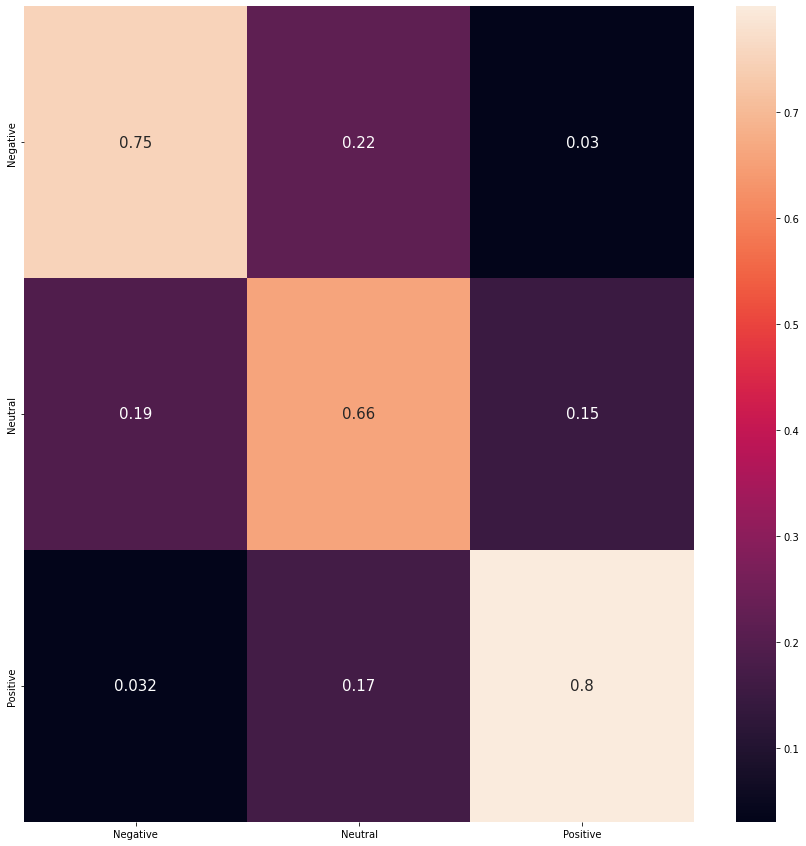

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = y.argmax(axis=1)
y_pred = y_pred_unproc.argmax(axis=1)

matrix = confusion_matrix(y_true, y_pred)

conf_matrix = pd.DataFrame(matrix, index = ['Negative','Neutral','Positive'],columns = ['Negative','Neutral','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})
plt.show()

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76      4990
           1       0.63      0.66      0.65      4991
           2       0.82      0.80      0.81      4991

    accuracy                           0.74     14972
   macro avg       0.74      0.74      0.74     14972
weighted avg       0.74      0.74      0.74     14972

